In [89]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.preprocessing import normalize
np.random.seed(0x5eed)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
num_bins = 10

In [90]:
df = pd.read_csv("data/cifar100/predictions.txt", sep='\s') 
id2class = dict(enumerate(set(df['Correct'])))
class2id = {id2class[k]: k for k in id2class}
print(id2class)

{0: 'lion', 1: 'chimpanzee', 2: 'trout', 3: 'orchid', 4: 'cloud', 5: 'maple_tree', 6: 'elephant', 7: 'mushroom', 8: 'bus', 9: 'orange', 10: 'cockroach', 11: 'shark', 12: 'palm_tree', 13: 'television', 14: 'clock', 15: 'otter', 16: 'cup', 17: 'poppy', 18: 'aquarium_fish', 19: 'possum', 20: 'lamp', 21: 'mouse', 22: 'pine_tree', 23: 'table', 24: 'house', 25: 'turtle', 26: 'sweet_pepper', 27: 'pear', 28: 'streetcar', 29: 'telephone', 30: 'whale', 31: 'bicycle', 32: 'sunflower', 33: 'lizard', 34: 'couch', 35: 'tiger', 36: 'butterfly', 37: 'hamster', 38: 'worm', 39: 'tulip', 40: 'lobster', 41: 'tractor', 42: 'spider', 43: 'woman', 44: 'seal', 45: 'bear', 46: 'tank', 47: 'fox', 48: 'beaver', 49: 'cattle', 50: 'squirrel', 51: 'castle', 52: 'boy', 53: 'girl', 54: 'crab', 55: 'kangaroo', 56: 'wolf', 57: 'plate', 58: 'skyscraper', 59: 'snake', 60: 'plain', 61: 'caterpillar', 62: 'bee', 63: 'bottle', 64: 'leopard', 65: 'motorcycle', 66: 'rabbit', 67: 'chair', 68: 'skunk', 69: 'crocodile', 70: 'law

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [136]:
# generate mapped data for padhraic
import csv
with open('data/cifar100/id2class_for_padhraic.csv', 'w') as f:
    for key in id2class.keys():
        f.write("%s,%s\n"%(key,id2class[key]))
df_ = pd.read_csv("data/cifar100/predictions.txt", sep='\s') 
df_['Correct'] = [class2id[_] for _ in df_['Correct']]
df_['Predicted'] = [class2id[_] for _ in df_['Predicted']]
df_.to_csv ('data/cifar100/predictions_mapped_for_padhraic.csv', index = None, header=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [98]:
def EceEval(confidence, y, num_bins=10):
    bins = np.linspace(0, 1, num_bins+1)
    digitized = np.digitize(confidence, bins[1:-1])
    
    w = np.array([(digitized==i).sum() for i in range(num_bins)])
    w = w/sum(w)

    confidence_bins = np.array([confidence[digitized==i].mean() for i in range(num_bins)])
    accuracy_bins = np.array([y[digitized==i].mean() for i in range(num_bins)])
    confidence_bins[np.isnan(confidence_bins)] = 0
    accuracy_bins[np.isnan(accuracy_bins)] = 0
    diff = np.absolute(confidence_bins - accuracy_bins)
    ece = np.inner(diff,w)
    return ece

In [126]:
column_names = ['Predicted_Class_k', 'R_k', 'N_k','Acc_k', 'Conf_k', 'ECE_k', 'Calibration_Bias_k']
output_df = pd.DataFrame(np.zeros((100,len(column_names))), columns = column_names) 

output_df['Predicted_Class_k'] = [id2class[id] for id in id2class]
output_df['R_k'] = [df[(df['Correct']==id2class[id]) & (df['Predicted']==id2class[id])].shape[0] for id in range(100)]
output_df['N_k'] = [df[(df['Predicted']==id2class[id])].shape[0] for id in range(100)]
output_df['Acc_k'] = output_df['R_k'] / output_df['N_k']
output_df['Conf_k'] = [df[(df['Predicted']==id2class[id])]['Confidence'].mean() for id in id2class]
output_df['Calibration_Bias_k'] = output_df['Conf_k'] - output_df['Acc_k']
for class_idx in range(100):
    mask = (df['Predicted']==id2class[class_idx])
    confidence = df[mask]['Confidence']
    y = df[mask]['Correct'] == df[mask]['Predicted']
    output_df['ECE_k'][class_idx] = EceEval(confidence, y, num_bins=num_bins)
output_df.to_csv('cifar100_output_df.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


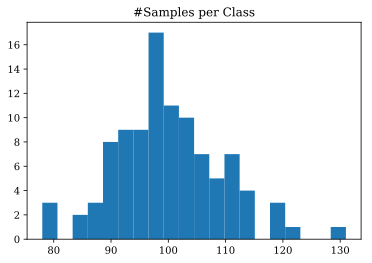

<Figure size 432x288 with 0 Axes>

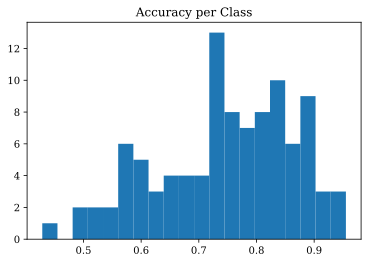

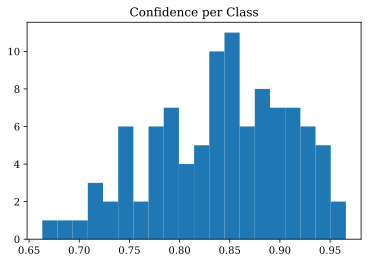

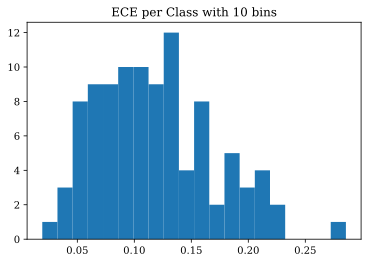

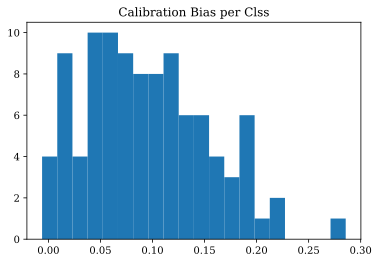

In [132]:
plt.figure();
plt.hist(output_df['N_k'],bins=20);
plt.title('#Samples per Class');
plt.figure();
plt.figure();
plt.hist(output_df['Acc_k'],bins=20);
plt.title('Accuracy per Class');
plt.figure();
plt.hist(output_df['Conf_k'],bins=20);
plt.title('Confidence per Class');
plt.figure();
plt.hist(output_df['ECE_k'],bins=20);
plt.title('ECE per Class with %d bins' % num_bins);
plt.figure();
plt.hist(output_df['Calibration_Bias_k'],bins=20);
plt.title('Calibration Bias per Clss');

In [130]:
# class with loweest accuracy
output_df.sort_values('Acc_k').head(n=10)

,Predicted_Class_k,R_k,N_k,Acc_k,Conf_k,ECE_k,Calibration_Bias_k
33,lizard,51,119,0.428571,0.714196,0.285624,0.285624
44,seal,52,104,0.500000,0.663175,0.177462,0.163175
15,otter,48,95,0.505263,0.720751,0.220323,0.215487
90,shrew,57,110,0.518182,0.726094,0.207912,0.207912
52,boy,49,93,0.526882,0.684300,0.157418,0.157418
45,bear,61,111,0.549550,0.742771,0.193222,0.193222
43,woman,60,109,0.550459,0.703017,0.152558,0.152558
34,couch,61,108,0.564815,0.756381,0.191567,0.191567
11,shark,61,107,0.570093,0.746573,0.180321,0.176479
75,baby,64,111,0.576577,0.795347,0.229134,0.218770


In [131]:
# class with loweest calibration bias
output_df.sort_values('Calibration_Bias_k').head(n=10)

,Predicted_Class_k,R_k,N_k,Acc_k,Conf_k,ECE_k,Calibration_Bias_k
32,sunflower,94,99,0.949495,0.943422,0.054671,-0.006073
12,palm_tree,87,94,0.925532,0.923293,0.019259,-0.002239
56,wolf,79,90,0.877778,0.877289,0.058224,-0.000489
77,keyboard,85,89,0.955056,0.954802,0.038674,-0.000254
87,beetle,76,92,0.826087,0.843817,0.042300,0.017730
65,motorcycle,91,96,0.947917,0.965794,0.045856,0.017877
93,wardrobe,90,97,0.927835,0.946529,0.057387,0.018694
88,pickup_truck,85,95,0.894737,0.914271,0.065662,0.019534
18,aquarium_fish,87,99,0.878788,0.898651,0.071562,0.019863
47,fox,76,92,0.826087,0.846685,0.112778,0.020598


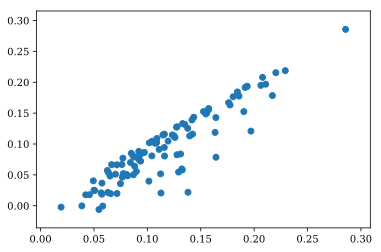

In [137]:
plt.scatter(output_df['ECE_k'], output_df['Calibration_Bias_k'])